# Import necessary modules

In [9]:
!pip install -U -q neurograd["all"]
import neurograd as ng
import os
import numpy as np
import gzip
import urllib.request

try:
    import cupy as cp
    # Clear all device memory
    cp.get_default_memory_pool().free_all_blocks()
    cp.get_default_pinned_memory_pool().free_all_blocks()
    cp.cuda.runtime.deviceSynchronize()
except ImportError:
    print("[INFO] CuPy not found – using NumPy (CPU) for the demo.")
    import numpy as cp

from matplotlib import pyplot as plt
import random

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.8 MB/s eta 0:00:00


# Prepare tiny ImageNet

In [10]:
# ================================================
# Tiny-ImageNet-200: download, extract, restructure,
# map WNIDs to words, then use ImageFolder + DataLoader
# ================================================
import os, zipfile, urllib.request
from pathlib import Path
from neurograd import Tensor, xp
from neurograd.utils.data import ImageFolder, DataLoader
import albumentations as A

# -------- config --------
DATA_DIR = Path("./data")
ZIP_PATH = DATA_DIR / "tiny-imagenet-200.zip"
ROOT     = DATA_DIR / "tiny-imagenet-200"
TRAIN    = ROOT / "train"
VAL      = ROOT / "val"
VAL_IMG  = VAL / "images"
VAL_ANN  = VAL / "val_annotations.txt"
WORDS_TXT = ROOT / "words.txt"

URLS = [
    "http://cs231n.stanford.edu/tiny-imagenet-200.zip",
    "https://tiny-imagenet.s3.amazonaws.com/tiny-imagenet-200.zip",  # fallback
]

BATCH_SIZE   = 256
IMG_SHAPE    = (227, 227)
IMG_MODE     = "RGB"
USE_ONE_HOT  = True
NUM_CLASSES  = 200

# -------- helpers --------
def download_with_fallback(urls, dst: Path):
    dst.parent.mkdir(parents=True, exist_ok=True)
    if dst.exists() and dst.stat().st_size > 0:
        print(f"[SKIP] {dst.name} already present.")
        return
    for url in urls:
        try:
            print(f"[DOWNLOAD] {url}")
            urllib.request.urlretrieve(url, dst)
            print("[OK] Downloaded.")
            return
        except Exception as e:
            print(f"[WARN] Failed: {e}")
    raise RuntimeError("All downloads failed.")

def extract_zip(zip_path: Path, out_dir: Path):
    if out_dir.exists() and (out_dir / "train").exists() and (out_dir / "val").exists():
        print("[SKIP] Already extracted.")
        return
    print(f"[EXTRACT] {zip_path} -> {out_dir.parent}")
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(out_dir.parent)
    print("[OK] Extracted.")

def restructure_train_inplace(train_dir: Path):
    for wnid in [p for p in train_dir.iterdir() if p.is_dir()]:
        images_dir = wnid / "images"
        if images_dir.is_dir():
            for img in images_dir.iterdir():
                if img.is_file():
                    os.replace(img, wnid / img.name)
            try:
                images_dir.rmdir()
            except OSError:
                pass
    print("[TRAIN] Restructured.")

def restructure_val_inplace(val_dir: Path):
    if not (val_dir / "images").exists():
        print("[VAL] Already restructured.")
        return
    mapping = {}
    with open(val_dir / "val_annotations.txt", "r") as f:
        for line in f:
            fname, wnid = line.strip().split("\t")[:2]
            mapping[fname] = wnid
    for fname, wnid in mapping.items():
        src = val_dir / "images" / fname
        dst_dir = val_dir / wnid
        dst_dir.mkdir(parents=True, exist_ok=True)
        os.replace(src, dst_dir / fname)
    try:
        (val_dir / "images").rmdir()
    except OSError:
        pass
    print("[VAL] Restructured.")

def load_wnid_to_words(words_file: Path):
    wnid_to_words = {}
    if not words_file.exists():
        print(f"[WARN] {words_file} not found. Using WNIDs as class names.")
        return wnid_to_words
    with open(words_file, "r") as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) >= 2:
                wnid = parts[0]
                words = parts[1].split(",")[0].strip()
                wnid_to_words[wnid] = words
    print(f"[OK] Loaded {len(wnid_to_words)} WNID->words mappings.")
    return wnid_to_words

def rename_directories_to_words(base_dir: Path, wnid_to_words: dict):
    if not wnid_to_words:
        print("[SKIP] No WNID mappings available.")
        return {}
    wnid_to_new_name, renamed_count = {}, 0
    for wnid_dir in [p for p in base_dir.iterdir() if p.is_dir()]:
        wnid = wnid_dir.name
        if wnid in wnid_to_words:
            clean_word = "".join(c if c.isalnum() else "_" for c in wnid_to_words[wnid]).strip("_")
            new_name = f"{wnid}_{clean_word}"
            new_dir = base_dir / new_name
            if not wnid_dir.name.endswith(f"_{clean_word}"):
                try:
                    wnid_dir.rename(new_dir)
                    wnid_to_new_name[wnid] = new_name
                    renamed_count += 1
                except OSError as e:
                    print(f"[WARN] Could not rename {wnid}: {e}")
                    wnid_to_new_name[wnid] = wnid
            else:
                wnid_to_new_name[wnid] = wnid_dir.name
        else:
            wnid_to_new_name[wnid] = wnid
    print(f"[OK] Renamed {renamed_count} directories with word labels.")
    return wnid_to_new_name

# -------- run prep --------
download_with_fallback(URLS, ZIP_PATH)
extract_zip(ZIP_PATH, ROOT)
restructure_train_inplace(TRAIN)
restructure_val_inplace(VAL)

# -------- load wnid mappings and rename directories --------
wnid_to_words = load_wnid_to_words(WORDS_TXT)
train_mapping = rename_directories_to_words(TRAIN, wnid_to_words)
val_mapping = rename_directories_to_words(VAL, wnid_to_words)

# -------- one-hot transform --------
def to_one_hot(idx: int, num_classes: int = NUM_CLASSES):
    v = xp.zeros((num_classes,), dtype=xp.float32)
    v[idx] = 1.0
    return v

target_tf = (lambda i: to_one_hot(i, NUM_CLASSES)) if USE_ONE_HOT else None
target_dtype = xp.float32 if USE_ONE_HOT else xp.int64

# -------- augmentations/datasets/loaders --------
train_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(
        translate_percent=(0.0625, 0.0625),
        scale=(0.90, 1.10),
        rotate=(-10, 10),
        fill_value=0,
        p=0.7
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.2,
        contrast_limit=0.2,
        p=0.7
    ),
    A.HueSaturationValue(
        hue_shift_limit=10,
        sat_shift_limit=15,
        val_shift_limit=10,
        p=0.5
    ),
    A.GaussNoise(
        var_limit=(5.0, 30.0),
        p=0.15
    ),
    A.MotionBlur(blur_limit=3, p=0.10),
    A.CoarseDropout(
        min_holes=1,
        max_holes=1,
        max_height=int(0.15 * IMG_SHAPE[0]),
        max_width=int(0.15 * IMG_SHAPE[1]),
        fill_value=0,
        p=0.5
    ),
])


train_ds = ImageFolder(
    root=str(TRAIN),
    img_shape=IMG_SHAPE,
    img_mode=IMG_MODE,
    img_normalize=True,
    # img_transform=train_aug,
    target_transform=target_tf,
    img_dtype=xp.float32,
    target_dtype=target_dtype,
    chw=True,
)

val_ds = ImageFolder(
    root=str(VAL),
    img_shape=IMG_SHAPE,
    img_mode=IMG_MODE,
    img_normalize=True,
    target_transform=target_tf,
    img_dtype=xp.float32,
    target_dtype=target_dtype,
    chw=True,
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, seed=42)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)

# -------- sanity check --------
Xb, yb = next(iter(train_loader))
print("Tiny-ImageNet batch:")
print("X:", Xb.shape, Xb.dtype)
print("y:", yb.shape, yb.dtype)

# Show class folder names
print("Sample class folder names:", sorted(os.listdir(TRAIN))[:10])

if wnid_to_words:
    print("\nSample WNID->words mappings:")
    for i, (wnid, word) in enumerate(list(wnid_to_words.items())[:10]):
        print(f"  {wnid}: {word}")

TARGET_MAPPING = train_ds.target_mapping
TARGET_INV_MAPPING = {v: k for k, v in TARGET_MAPPING.items()}
TARGET_NAMES = train_ds.target_names
print(f"\nTotal classes: {train_ds.num_classes}")
print("First 10 class names:", TARGET_NAMES[:10])

[SKIP] tiny-imagenet-200.zip already present.
[SKIP] Already extracted.
[TRAIN] Restructured.
[VAL] Already restructured.
[OK] Loaded 82115 WNID->words mappings.
[OK] Renamed 0 directories with word labels.
[OK] Renamed 0 directories with word labels.


/tmp/ipykernel_36/2906080918.py:154: UserWarning: Argument(s) 'fill_value' are not valid for transform Affine
  A.Affine(
/tmp/ipykernel_36/2906080918.py:172: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(
/tmp/ipykernel_36/2906080918.py:177: UserWarning: Argument(s) 'min_holes, max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(


Tiny-ImageNet batch:
X: (256, 3, 227, 227) <class 'numpy.float32'>
y: (256, 200) <class 'numpy.float32'>
Sample class folder names: ['n01443537_goldfish', 'n01629819_European_fire_salamander', 'n01641577_bullfrog', 'n01644900_tailed_frog', 'n01698640_American_alligator', 'n01742172_boa_constrictor', 'n01768244_trilobite', 'n01770393_scorpion', 'n01774384_black_widow', 'n01774750_tarantula']

Sample WNID->words mappings:
  n00001740: entity
  n00001930: physical entity
  n00002137: abstraction
  n00002452: thing
  n00002684: object
  n00003553: whole
  n00003993: congener
  n00004258: living thing
  n00004475: organism
  n00005787: benthos

Total classes: 200
First 10 class names: ['n01443537_goldfish', 'n01629819_European_fire_salamander', 'n01641577_bullfrog', 'n01644900_tailed_frog', 'n01698640_American_alligator', 'n01742172_boa_constrictor', 'n01768244_trilobite', 'n01770393_scorpion', 'n01774384_black_widow', 'n01774750_tarantula']


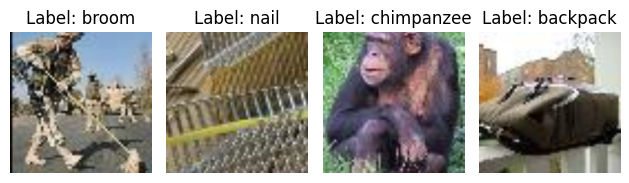

In [11]:
# Plot 4 random images

indices = range(len(train_ds))
chosen = random.sample(indices, 4)

for i, idx in enumerate(chosen, 1):
  plt.subplot(1, 4, i)
  img, label = train_ds[idx]
  img = img.data.transpose(1, 2, 0).get()
  label = TARGET_INV_MAPPING.get(label.data.argmax().item()).split("_")[1]
  plt.axis("off")
  plt.imshow(img)
  plt.title(f"Label: {label}")
plt.tight_layout()
plt.show()

# Model architecture, optimizer and losses

In [12]:
from neurograd.nn.layers import Conv2D, MaxPool2D, Flatten, Linear, Sequential, Dropout

model = Sequential(
    Conv2D(3, 96, 11, strides=4, activation="relu"),
    MaxPool2D(3, strides=2),
    Conv2D(96, 256, 5, padding="same", activation="relu"),
    MaxPool2D(3, strides=2),
    Conv2D(256, 384, 3, padding="same", activation="relu"),
    Conv2D(384, 384, 3, padding="same", activation="relu"),
    Conv2D(384, 256, 3, padding="same", activation="relu"),
    MaxPool2D(3, strides=2),
    Flatten(),
    Linear(9216, 4096, activation="relu"),
    Linear(4096, 4096, activation="relu"),
    Linear(4096, NUM_CLASSES)
)


for name, param in model.named_parameters():
  print(name, param.shape)

layer_0.kernels (96, 3, 11, 11)
layer_0.bias (1, 96, 1, 1)
layer_2.kernels (256, 96, 5, 5)
layer_2.bias (1, 256, 1, 1)
layer_4.kernels (384, 256, 3, 3)
layer_4.bias (1, 384, 1, 1)
layer_5.kernels (384, 384, 3, 3)
layer_5.bias (1, 384, 1, 1)
layer_6.kernels (256, 384, 3, 3)
layer_6.bias (1, 256, 1, 1)
layer_9.weight (9216, 4096)
layer_9.bias (4096,)
layer_10.weight (4096, 4096)
layer_10.bias (4096,)
layer_11.weight (4096, 200)
layer_11.bias (200,)


In [13]:
from neurograd.optim import Adam, SGD
from neurograd.nn.losses import CategoricalCrossEntropy
from neurograd.nn.metrics import accuracy_score

optimizer = Adam(model.named_parameters(), lr=1e-4)
loss_fn = CategoricalCrossEntropy(from_logits=True)

# Training (mixed precision)

In [ ]:
from tqdm.auto import tqdm
from neurograd.amp import GradScaler
from contextlib import nullcontext

# ======== CONFIG ========
USE_AMP = True  # Toggle mixed precision on/off
EPOCHS = 100
BATCH_SIZE = train_loader.batch_size
# ========================

scaler = GradScaler() if USE_AMP else None

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch: {epoch} / {EPOCHS}:")
    train_losses, train_acc = [], []
    test_losses, test_acc = [], []
    model.train()
    ng.save(model, "model.pkl")
    for (X_train, y_train) in tqdm(train_loader):
        ctx = ng.autocast() if USE_AMP else nullcontext()
        with ctx:
            y_pred = model(X_train)
            loss = loss_fn(y_train, y_pred)
            # print(loss.data, loss.data.dtype)
            train_losses.append(loss.data)
            optimizer.zero_grad()
            if USE_AMP:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()
            acc = accuracy_score(y_train.argmax(axis=-1), y_pred.argmax(axis=-1))
            train_acc.append(acc)

    model.eval()
    for (X_test, y_test) in val_loader:
        ctx = ng.autocast() if USE_AMP else nullcontext()
        with ctx:
            y_pred = model(X_test)
            loss = loss_fn(y_test, y_pred)
            acc = accuracy_score(y_test.argmax(axis=-1), y_pred.argmax(axis=-1))
            test_losses.append(loss.data)
            test_acc.append(acc)

    # Convert lists to arrays before mean
    train_losses = cp.asarray(train_losses)
    train_acc = cp.asarray(train_acc)
    test_losses = cp.asarray(test_losses)
    test_acc = cp.asarray(test_acc)

    print(
        f"Train loss: {cp.nanmean(train_losses):.4f}, "
        f"Train acc: {cp.mean(train_acc):.4f}, "
        f"Test loss: {cp.nanmean(test_losses):.4f}, "
        f"Test acc: {cp.mean(test_acc):.4f}"
    )

Epoch: 1 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 4.7652, Train acc: 0.0590, Test loss: 4.3367, Test acc: 0.1063
Epoch: 2 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

In [ ]:
from tqdm.auto import tqdm
from neurograd.amp import GradScaler
from contextlib import nullcontext

# ======== CONFIG ========
USE_AMP = True  # Toggle mixed precision on/off
EPOCHS = 100
BATCH_SIZE = train_loader.batch_size
# ========================

scaler = GradScaler() if USE_AMP else None

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch: {epoch} / {EPOCHS}:")
    train_losses, train_acc = [], []
    test_losses, test_acc = [], []
    model.train()
    ng.save(model, "model.pkl")
    for (X_train, y_train) in tqdm(train_loader):
        ctx = ng.autocast() if USE_AMP else nullcontext()
        with ctx:
            y_pred = model(X_train)
            loss = loss_fn(y_train, y_pred)
            # print(loss.data, loss.data.dtype)
            train_losses.append(loss.data)
            optimizer.zero_grad()
            if USE_AMP:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()
            acc = accuracy_score(y_train.argmax(axis=-1), y_pred.argmax(axis=-1))
            train_acc.append(acc)

    model.eval()
    for (X_test, y_test) in val_loader:
        ctx = ng.autocast() if USE_AMP else nullcontext()
        with ctx:
            y_pred = model(X_test)
            loss = loss_fn(y_test, y_pred)
            acc = accuracy_score(y_test.argmax(axis=-1), y_pred.argmax(axis=-1))
            test_losses.append(loss.data)
            test_acc.append(acc)

    # Convert lists to arrays before mean
    train_losses = cp.asarray(train_losses)
    train_acc = cp.asarray(train_acc)
    test_losses = cp.asarray(test_losses)
    test_acc = cp.asarray(test_acc)

    print(
        f"Train loss: {cp.nanmean(train_losses):.4f}, "
        f"Train acc: {cp.mean(train_acc):.4f}, "
        f"Test loss: {cp.nanmean(test_losses):.4f}, "
        f"Test acc: {cp.mean(test_acc):.4f}"
    )

Epoch: 1 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 5.0327, Train acc: 0.0295, Test loss: 4.7272, Test acc: 0.0563
Epoch: 2 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 4.6225, Train acc: 0.0702, Test loss: 4.4510, Test acc: 0.0909
Epoch: 3 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 4.3520, Train acc: 0.1032, Test loss: 4.2138, Test acc: 0.1251
Epoch: 4 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 4.1394, Train acc: 0.1316, Test loss: 4.0652, Test acc: 0.1527
Epoch: 5 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.9577, Train acc: 0.1572, Test loss: 3.9694, Test acc: 0.1595
Epoch: 6 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.7911, Train acc: 0.1820, Test loss: 3.8172, Test acc: 0.1879
Epoch: 7 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.6336, Train acc: 0.2062, Test loss: 3.8057, Test acc: 0.1940
Epoch: 8 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.4628, Train acc: 0.2333, Test loss: 3.7132, Test acc: 0.2159
Epoch: 9 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.2992, Train acc: 0.2623, Test loss: 3.7527, Test acc: 0.2145
Epoch: 10 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.1209, Train acc: 0.2900, Test loss: 3.7484, Test acc: 0.2197
Epoch: 11 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.9191, Train acc: 0.3249, Test loss: 3.8562, Test acc: 0.2208
Epoch: 12 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.7311, Train acc: 0.3594, Test loss: 3.8038, Test acc: 0.2317
Epoch: 13 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.5444, Train acc: 0.3942, Test loss: 4.0608, Test acc: 0.2219
Epoch: 14 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

# Visualize model predictions

In [ ]:
# Plot 4 random predictions from validation set
X, y = random.choice(val_loader)

with ng.autocast():
    y_pred = model(X)

indices = range(len(X))
chosen = random.sample(indices, 4)

correct = 0
for i, idx in enumerate(chosen, 1):
    plt.subplot(1, 4, i)
    img = X[idx].data.transpose(1, 2, 0).get()  # Convert CHW to HWC

    if USE_ONE_HOT:
        label = y[idx].data.argmax(-1).item()
        pred = y_pred[idx].data.argmax(-1).item()
    else:
        label = y[idx].data.item()
        pred = y_pred[idx].data.argmax(-1).item()

    correct += (label == pred)

    # Get human-readable class names
    label_name = TARGET_NAMES[label] if label < len(TARGET_NAMES) else str(label)
    pred_name = TARGET_NAMES[pred] if pred < len(TARGET_NAMES) else str(pred)

    plt.axis("off")
    plt.imshow(img)
    plt.title(f"Label: {label_name}\nPred: {pred_name}")

plt.tight_layout()
plt.show()
print(f"Guessed {correct} / 4")